# AI Generated Heatmaps part 2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Vectorized dataset creation, with scaling
This method runs much faster than iterating through arrays and doesn't need multithreading. 

Also, there is the option to scale the heatmap to control how the intensity from the sources decays as you move away from them. Essentially this transforms $\text{heatmap}\rightarrow log(\text{heatmap})$. Since the heatmap might have $0$'s, these have to be replaced to avoid taking $log(0)$. This is controlled with the `min_element` parameter. 

Eg if `min_element=1` we replace any matrix values less than $1$ with $1$, Smaller `min_element_pct` makes the "glow" around each source increase.

In [2]:
def create_random_source(i_lims=(0,100), x_max=10, y_max=10):
    """ Creates a tuple that represents a source with random x,y,intensity"""
    intensity = round(i_lims[0] + np.random.random()*(i_lims[1]-i_lims[0]),2)
    x = int(np.random.random()  * x_max)
    y = int(np.random.random() * y_max)
    return intensity, x ,y


def make_source_matrix(m,n, sources):
    """Makes a matrix that is 0 everywhere except where there is a source, where the value is the source intensity
        m x n is the output matrix size
        s is a list of 'sources' [[intensity_0, x_0, y_0],[intensity_1, x_1, y_1],...]
    """
    source_dist = np.zeros((m, n))
    for source in sources:
        intensity,x,y = source
        source_dist[y,x] = intensity   
        # source_dist[int(y),int(x)] = intensity   
    return source_dist


def make_intensity_matrix(m,n,sources, xx=None, yy=None):
    """Creates a matrix representing"""
    # create meshgrid if one was not passed
    if xx is None:
        xx,yy = np.meshgrid(np.arange(0, n), np.arange(0, m)) # grid of x,y values
    intensity_matrix = np.zeros((m, n))
    
    for source in sources:
        intensity,x,y = source
        
        # calculate distance from every position in grid to source
        distances = np.sqrt((xx - x)**2 + (yy - y)**2) 
        
        # replace distance=0 with 1 to avoid div/0
        distances = np.where(distances==0, 1, distances) 
        
        # add intensity from source using inverse-square law
        intensity_matrix += intensity / distances**2   
        
    return intensity_matrix


def log_scale_matrix(matrix, min_element=1):
    """Transforms matrix values by taking log of each element. 
    Replaces small values to avoid -inf when taking log
    """
    transf = np.where(matrix<min_element, min_element, matrix)
    return np.log(transf) 


def inverse_log_scale_matrix(matrix, min_element=1):
    """performs inverse transformation to `log_scale_matrix()` """
    matrix = np.exp(matrix) 
    return np.where(matrix==min_element, 0, matrix)


def plot_heatmap(data, title = "", height = 3, cmap="viridis", norm="linear"):  
    """plots a heatmap with colorbar"""
    plt.figure(figsize=(height,height))
    img = plt.imshow(data, cmap=cmap, interpolation='nearest', norm=norm)
    plt.gca().invert_yaxis()
    plt.colorbar(img,fraction=0.046, pad=0.04)
    plt.title(title)
    plt.tight_layout()
    return

# Making random sources
Sources are made, then used to produce an intensity matrix that models the inverse-square law.

In [3]:
def plot_source_intensity_heatmaps(sources, intensity, height = 3, cmap = "plasma"):
    fig, axes = plt.subplots(1, 2, figsize=(2*height, height))

    # Plot original heatmap
    im0 = axes[0].imshow(sources, cmap=cmap, origin='lower')
    axes[0].set_title("Sparse input")
    fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)

    # Plot original heatmap
    im1 = axes[1].imshow(intensity, cmap=cmap, origin='lower')
    axes[1].set_title("Simulated Intensity")
    fig.colorbar(im1, ax=axes[1],fraction=0.046, pad=0.04)

    
    plt.tight_layout()
    plt.show()
    return

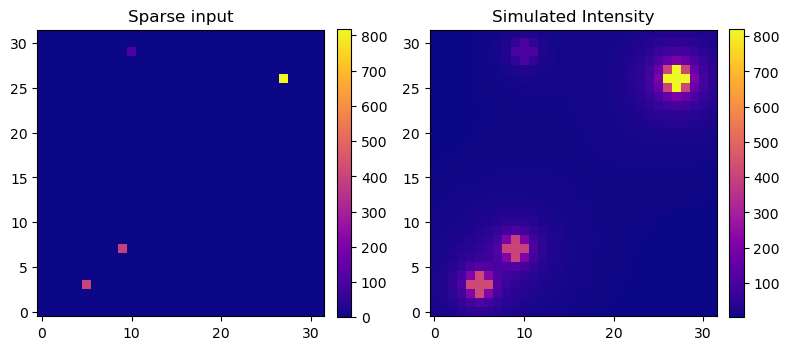

In [4]:
heatmap_w, heatmap_h = 32,32
n_sources=4

source_min = 50  # This ensures it will be visible 
source_max = 1000

# grid of x,y values used to calculate distances
xx,yy = np.meshgrid(np.arange(0, heatmap_w), np.arange(0, heatmap_h)) 

sources = []
for _ in range(n_sources):
    sources.append(create_random_source((source_min,source_max), heatmap_w, heatmap_h))

source_matrix = make_source_matrix(heatmap_h,heatmap_w, sources) 
intensity_heatmap = make_intensity_matrix(heatmap_h,heatmap_w,sources)   

plot_source_intensity_heatmaps(source_matrix, intensity_heatmap, height = 4)

## Scaling data

If we want to log-scale the data, use the `log_scale_matrix()` funtion. This has the effect of creating a larger "halo" around each source before they decay to very small intensities.

The "size of the halo" is controlled with the `min_element` parameter. Smaller values create a larger "halo". It should be parametrized better as a fraction of the maximum source intensity, but for now it's an absolute number

min_element=100.0


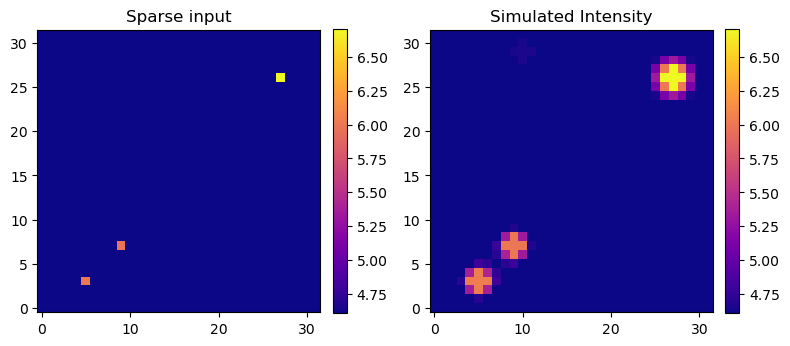

In [5]:
min_element = 0.1 * source_max
print(f"min_element={min_element}")

log_source_matrix = log_scale_matrix(source_matrix, min_element)
log_intensity_heatmap = log_scale_matrix(intensity_heatmap, min_element)

plot_source_intensity_heatmaps(log_source_matrix, log_intensity_heatmap, height = 4)

min_element=1.0


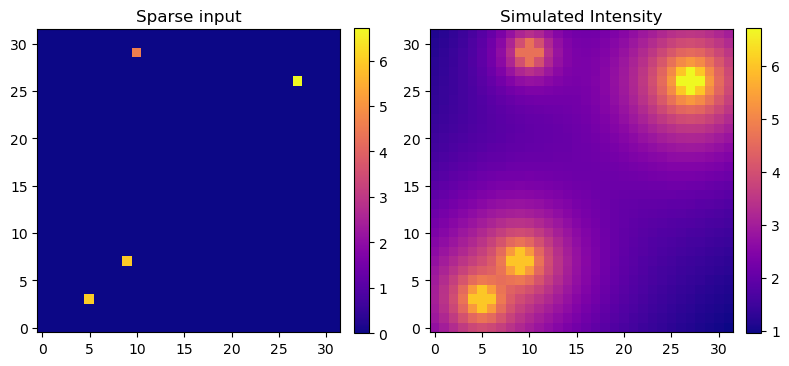

In [6]:
min_element = 0.001 * source_max
print(f"min_element={min_element}")

log_source_matrix = log_scale_matrix(source_matrix, min_element)
log_intensity_heatmap = log_scale_matrix(intensity_heatmap, min_element)

plot_source_intensity_heatmaps(log_source_matrix, log_intensity_heatmap, height = 4)

# Make Dataset and Examine Some Samples

Initially we will try without scaling the heatmap

In [7]:
def generate_dataset_vectorized(m, n, num_heatmaps=10, num_sources=3, 
                                source_min=0,source_max=100,
                                log_scale=False, min_element = 1):
    """Generates dataset of source matrices (location,intensity of sources) and 
    heatmap matrices (location, intensity due to all sources, obeying inverse-square law)
    PARAMETERS:
        m(int):              Number of rows in matrix (height)
        n(int):              Number of columns in matrix (width)
        num_heatmaps(int):   Number of heatmaps to generate
        num_sources(int):    Number of sources to create (with random intensity,x,y)
        source_min(numeric): Minimum intensity to draw random intensities from
        source_max(numeric): Maximum intensity to draw random intensities from
        log_scale(bool):     Whether heatmap intensity should be log scaled
        min_element(float):  If log_scale==True, replace intensities below this value with this value (avoids -inf)
    """
    xx,yy = np.meshgrid(np.arange(0, n), np.arange(0, m)) # grid of x,y values
    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    source_matrices = np.zeros((num_heatmaps, m, n))

    for i in range(num_heatmaps):
        
        # make a bunch of random sources and store in matrix
        sources = []
        for _ in range(num_sources):
            sources.append(create_random_source((source_min,source_max), m, n))
        source_matrix = make_source_matrix(m,n, sources) 
        
        # use sources to make intensity matrix
        for source in sources:
            intensity_matrix = make_intensity_matrix(m,n,sources, xx, yy)   
        
        # scale values using log if specified
        if log_scale==True:
            source_matrices[i] = log_scale_matrix(source_matrix, min_element)
            heatmap_matrices[i] = log_scale_matrix(intensity_matrix, min_element)
        else:
            source_matrices[i] = source_matrix
            heatmap_matrices[i] = intensity_matrix 
            
    return source_matrices, heatmap_matrices


In [8]:
%%time

heatmap_w, heatmap_h = 32, 32
num_heatmaps = 10000

num_sources=3
source_min = 100
source_max = 1000

log_scale=False   
min_element=None

Xs, Ys = generate_dataset_vectorized(
    heatmap_h, heatmap_w, num_heatmaps, num_sources, 
    source_min,source_max,log_scale, min_element)

CPU times: user 848 ms, sys: 57.3 ms, total: 905 ms
Wall time: 904 ms


sample #7861, log_scale=False


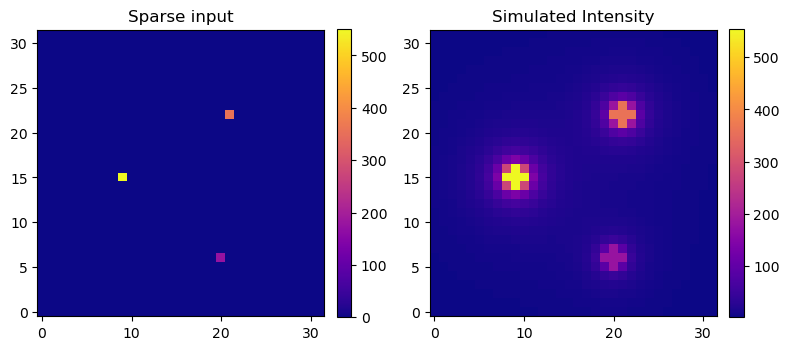

In [9]:
# Look at a random sample (re-run for a new sample)

idx = np.random.randint(Xs.shape[0])
print(f"sample #{idx}, log_scale={log_scale}")
plot_source_intensity_heatmaps(Xs[idx], Ys[idx], height = 4)

# Build sequential NN model

In [10]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Identity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU

def build_model_leaky(n_inputs, hidden_layers=[10, 10, 10], n_out=1, dropout=0., alpha=0.3):
    """
    builds a neural network using the depth and layer sizes provided by hidden_layers arg
    choose an activation function from the supported functions in activations
    
    when Keras initializes the weights and biases, they're set to random values, this can 
    cause each instance of the model to perform radically differently 
    
    As such, when we compare the results for different epochs, normalization, etc. the 
    weights and biases should be set using the same seed and initializer
    """
    initializer = GlorotUniform(seed=808)
    
    model = Sequential()
    for i, layer in enumerate(hidden_layers):
        if i == 0:
            # define the input shape based on n_inputs
            model.add(Dense(hidden_layers[i], input_shape=(n_inputs,), kernel_initializer=initializer))
            # model.add(LeakyReLU(alpha = alpha))
            model.add(Identity())
        else:
            model.add(Dropout(dropout))
            model.add(BatchNormalization())
            # base the input shape on the previous layer
            model.add(Dense(hidden_layers[i], input_shape=(hidden_layers[i-1],), kernel_initializer=initializer))
            # model.add(LeakyReLU(alpha = alpha))
            model.add(Identity())
    
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # add our output layer
    model.add(Dense(n_out, input_shape=(hidden_layers[len(hidden_layers)-1],), kernel_initializer=initializer))
    
    # build the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [11]:
def plot_compare_heatmaps(input, original, predicted):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # set colorscale max and min
    min_i = max(input.min(), original.min(), predicted.min()) 
    max_i = max(input.max(), original.max(), predicted.max())
    
    # Plot original heatmap
    im0 = axes[0].imshow(input, cmap='plasma', origin='lower')
    axes[0].set_title("Sparse input")
    fig.colorbar(im0, ax=axes[0],fraction=0.046, pad=0.04)
    im0.set_clim(vmin=min_i, vmax=max_i)

    # Plot original heatmap
    im1 = axes[1].imshow(original, cmap='plasma', origin='lower')
    axes[1].set_title("Simulated Intensity")
    fig.colorbar(im1, ax=axes[1],fraction=0.046, pad=0.04)
    im1.set_clim(vmin=min_i, vmax=max_i)

    # Plot predicted heatmap
    im2 = axes[2].imshow(predicted, cmap='plasma', origin='lower')
    axes[2].set_title("Predicted Intensity")
    fig.colorbar(im2, ax=axes[2],fraction=0.046, pad=0.04)
    im2.set_clim(vmin=min_i, vmax=max_i)

    plt.tight_layout()
    plt.show()

In [12]:
# Reshape and split data for model

Xs_reshaped = Xs.reshape((num_heatmaps, heatmap_w*heatmap_h))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))

X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 1024) (8000, 1024)
(2000, 1024) (2000, 1024)


In [13]:
n_epochs = 100
hidden_layers = [8192, 8192]
batch_size = 512
alpha = 0.2

best_model_name = 'best_linear_dispersion_model.h5'

# saving the best model weights
checkpoint = ModelCheckpoint(best_model_name, 
    verbose=0, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
model = build_model_leaky(heatmap_w*heatmap_h, hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 7058.6440 - mean_squared_error: 7058.6440

/Users/trevorkinsey/opt/miniconda3/envs/ml2/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 13s 835ms/step - loss: 7058.6440 - mean_squared_error: 7058.6440 - val_loss: 15371.8643 - val_mean_squared_error: 15371.8643
Epoch 2/100
16/16 [==============================] - 13s 796ms/step - loss: 5474.6299 - mean_squared_error: 5474.6299 - val_loss: 12907.9502 - val_mean_squared_error: 12907.9502
Epoch 3/100
16/16 [==============================] - 11s 713ms/step - loss: 4403.5811 - mean_squared_error: 4403.5811 - val_loss: 7607.5552 - val_mean_squared_error: 7607.5552
Epoch 4/100
16/16 [==============================] - 12s 734ms/step - loss: 3556.6685 - mean_squared_error: 3556.6685 - val_loss: 4715.9902 - val_mean_squared_error: 4715.9902
Epoch 5/100
16/16 [==============================] - 12s 727ms/step - loss: 2824.4175 - mean_squared_error: 2824.4175 - val_loss: 3540.7139 - val_mean_squared_error: 3540.7139
Epoch 6/100
16/16 [==============================] - 12s 728ms/step - loss: 2199.2698 - mean_squared_error: 2199.2698 - val_loss

In [14]:
# # load saved model to avoid re-training
# best_model_name = 'best_linear_dispersion_model.h5'
# model = keras.models.load_model(best_model_name)

In [15]:
preds = model.predict(X_test)

63/63 [==============================] - 2s 25ms/step


sample 1771, RMSE = 10.79


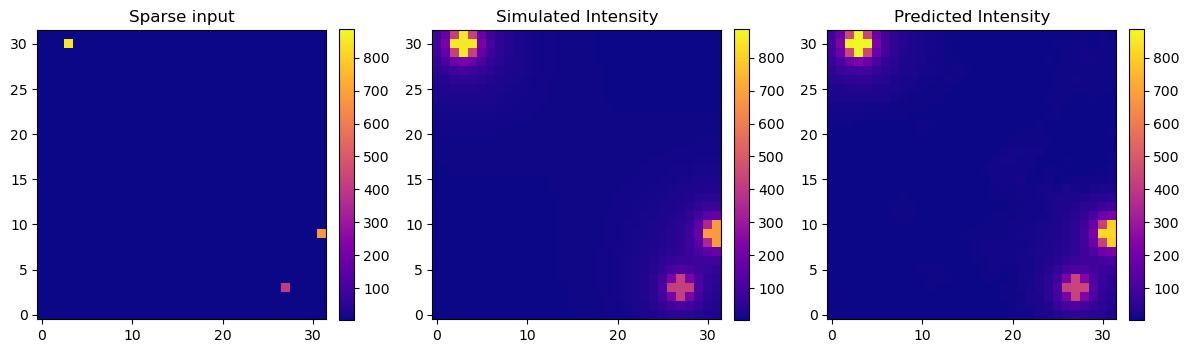

sample 590, RMSE = 4.87


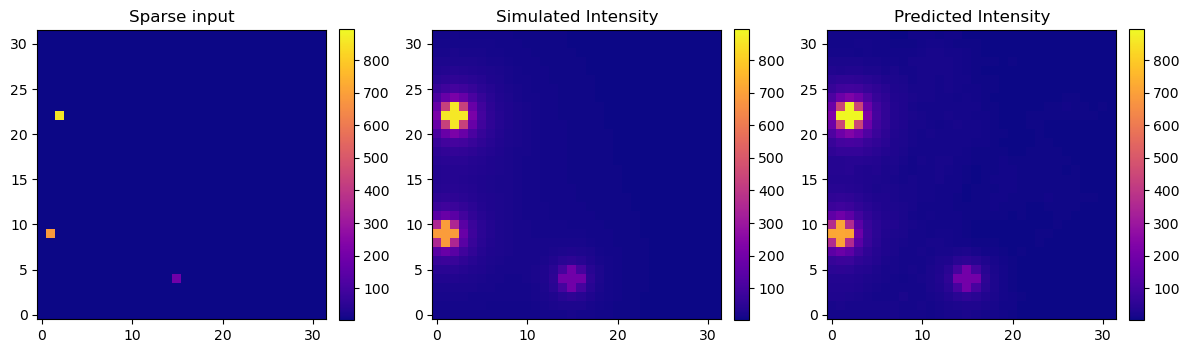

In [16]:
n_samples = 2
for _ in range(n_samples):
    idx = np.random.randint(X_test.shape[0])
    rmse = np.sqrt((np.square(preds[idx] - y_test[idx])).mean())
    print(f"sample {idx}, RMSE = {round(rmse,2)}")
    plot_compare_heatmaps(X_test[idx].reshape((heatmap_w, heatmap_h)), y_test[idx].reshape((heatmap_w, heatmap_h)), preds[idx].reshape((heatmap_w,heatmap_h)))

**Note:** This is working very well!

# Repeat with log-scaled inputs
Above the model predicted inverse-square distributions. Can it predict other ones?

Test this by taking the inverse-square distribution that we used above then log-scaling it to make the heatmap values decay slower as the distance from the sources increase. 


In [17]:
heatmap_w, heatmap_h = 32, 32
num_heatmaps = 10000  

num_sources=3
source_min = 100
source_max = 1000

# use same dataset parameters as aboves, except for:
log_scale=True   
min_element = 0.04 * source_max # intensities below 4% of source_max set to 4% of source_max
min_element=1

Xs, Ys = generate_dataset_vectorized(heatmap_h, heatmap_w, num_heatmaps, num_sources, source_min, source_max, log_scale, min_element)

sample #8988, log_scale=True


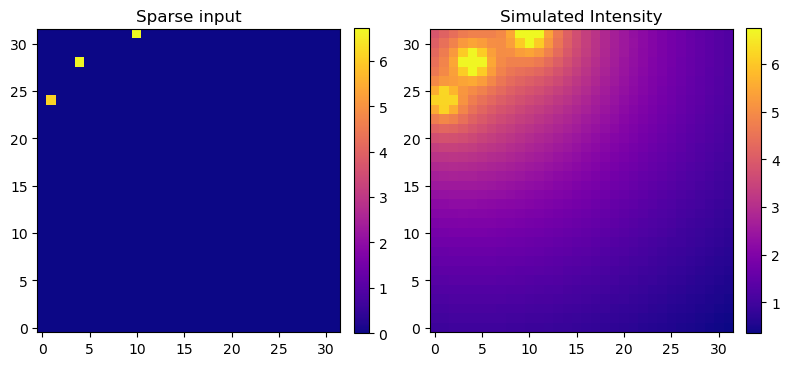

In [18]:
# Look at a random sample (re-run for a new sample) to check the "halo" size

idx = np.random.randint(Xs.shape[0])
print(f"sample #{idx}, log_scale={log_scale}")
plot_source_intensity_heatmaps(Xs[idx], Ys[idx], height = 4)

There is more of a "halo" around each source than before scaling

In [19]:
Xs_reshaped = Xs.reshape((num_heatmaps, heatmap_w*heatmap_h))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))

X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8000, 1024) (8000, 1024)
(2000, 1024) (2000, 1024)


In [20]:
n_epochs = 100
hidden_layers = [8192, 8192]
batch_size = 512
alpha = 0.2

best_model_name = 'best_linear_dispersion_model_scaled.h5'

# saving the best model weights
checkpoint = ModelCheckpoint(best_model_name, 
    verbose=0, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
scaled_model = build_model_leaky(heatmap_w*heatmap_h, hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = scaled_model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/100
16/16 [==============================] - 13s 797ms/step - loss: 7.2450 - mean_squared_error: 7.2450 - val_loss: 5.8393 - val_mean_squared_error: 5.8393
Epoch 2/100
16/16 [==============================] - 12s 775ms/step - loss: 5.1511 - mean_squared_error: 5.1511 - val_loss: 3.3636 - val_mean_squared_error: 3.3636
Epoch 3/100
16/16 [==============================] - 12s 761ms/step - loss: 2.9221 - mean_squared_error: 2.9221 - val_loss: 1.3588 - val_mean_squared_error: 1.3588
Epoch 4/100
16/16 [==============================] - 12s 731ms/step - loss: 1.0763 - mean_squared_error: 1.0763 - val_loss: 0.6144 - val_mean_squared_error: 0.6144
Epoch 5/100
16/16 [==============================] - 12s 773ms/step - loss: 0.4584 - mean_squared_error: 0.4584 - val_loss: 0.5829 - val_mean_squared_error: 0.5829
Epoch 6/100
16/16 [==============================] - 12s 726ms/step - loss: 0.3586 - mean_squared_error: 0.3586 - val_loss: 0.5424 - val_mean_squared_error: 0.5424
Epoch 7/100
16/1

In [21]:
# # load saved model to avoid re-training
# best_model_name = 'best_linear_dispersion_model_scaled.h5'
# scaled_model = keras.models.load_model(best_model_name)

In [22]:
preds = scaled_model.predict(X_test)

63/63 [==============================] - 2s 25ms/step


hidden_layers=[8192, 8192]
sample 675, RMSE = 0.32


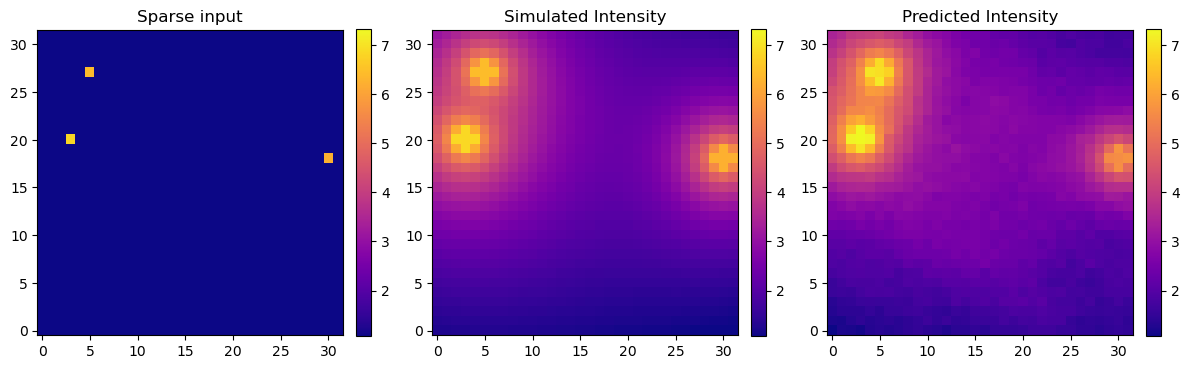

sample 1193, RMSE = 0.36


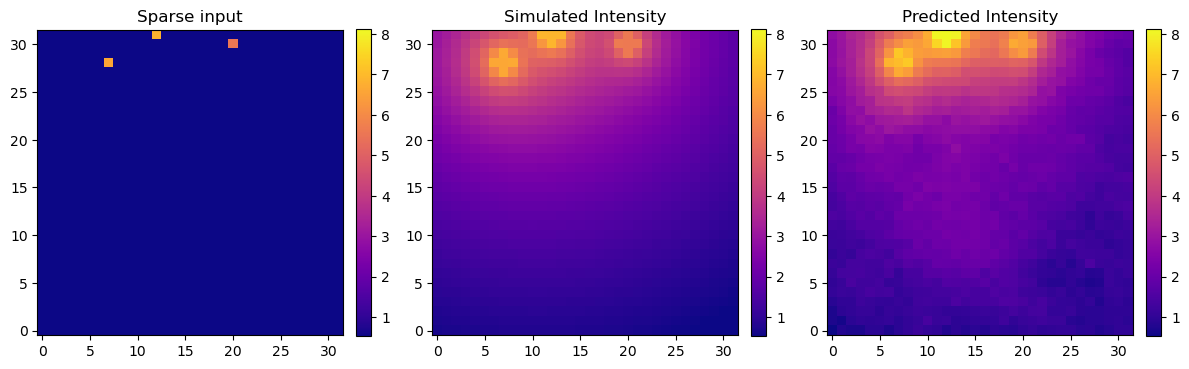

In [23]:
print(f"hidden_layers={hidden_layers}")
n_samples = 2
for _ in range(n_samples):
    idx = np.random.randint(X_test.shape[0])
    rmse = np.sqrt((np.square(preds[idx] - y_test[idx])).mean())
    print(f"sample {idx}, RMSE = {round(rmse,2)}")
    plot_compare_heatmaps(X_test[idx].reshape((heatmap_w, heatmap_h)), y_test[idx].reshape((heatmap_w, heatmap_h)), preds[idx].reshape((heatmap_w,heatmap_h)))

**Note:** Scaling the data resulted in predictions that are a bit noisier than unscaled, but looks pretty good. 

The RMSE is not easy to compare to the non-scaled values, but if we try to de-log-scale them we might get a better idea how the model did in comparison.

sample 1193, RMSE = 161.7


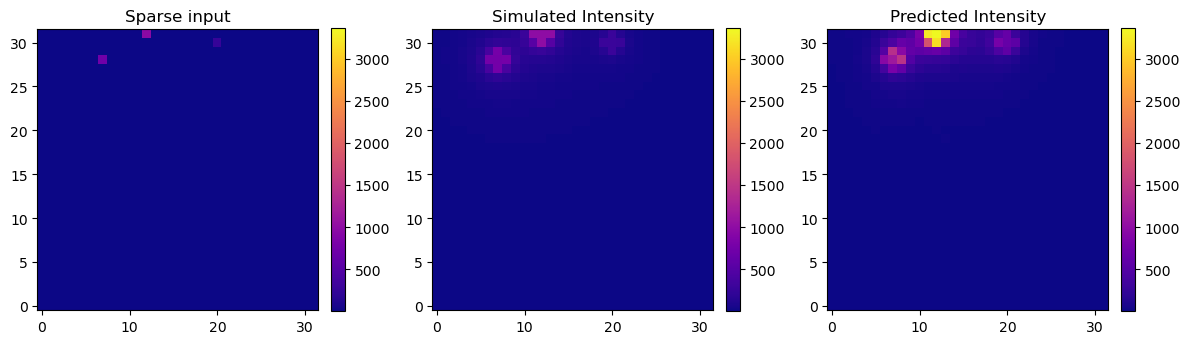

In [24]:
descaled_sources = inverse_log_scale_matrix(X_test[idx].reshape((heatmap_w, heatmap_h)), min_element)
descaled_y = inverse_log_scale_matrix(y_test[idx].reshape((heatmap_w, heatmap_h)), min_element)
descaled_pred = inverse_log_scale_matrix(preds[idx].reshape((heatmap_w,heatmap_h)), min_element)

rmse = np.sqrt((np.square(descaled_y - descaled_pred)).mean())
print(f"sample {idx}, RMSE = {round(rmse,1)}")

plot_compare_heatmaps(descaled_sources, descaled_y, descaled_pred)

Well this isn't perfect, but does capture the positions well and intensities less well.

## Can we input arbitrary sources / intensites in our sparse matrix. 

The previous model learned to approximate the 2D heatmap algorithm from a fixed number of sparse inputs but can we input arbitrary number / intensity of sources into this model and have it predict the heatmap?

In [30]:
# use random sources
num_random_sources = 6
test_sources = []

for _ in range(num_random_sources):
    test_sources.append(create_random_source((source_min,source_max), heatmap_w, heatmap_h))
    
test_sources

[(181.26, 8, 6),
 (909.89, 15, 4),
 (238.01, 7, 20),
 (580.97, 1, 8),
 (322.09, 20, 21),
 (518.28, 22, 22)]

### Unscaled data

1 sources,  RMSE = 1.3


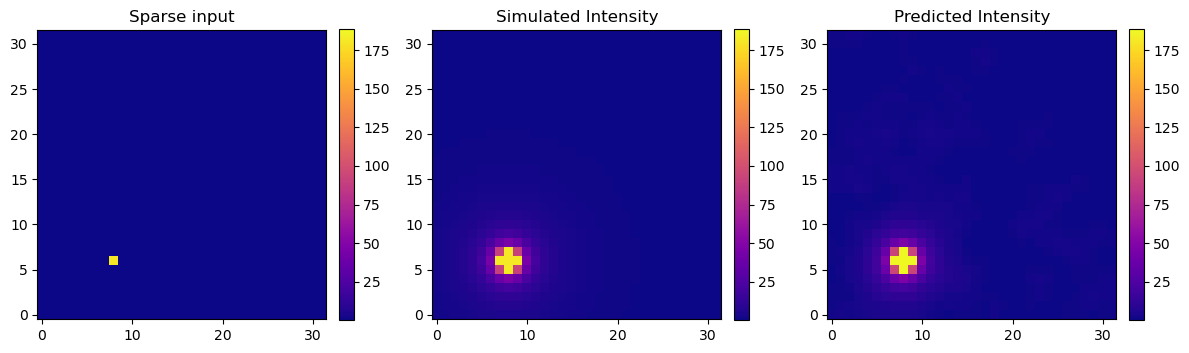

2 sources,  RMSE = 4.0


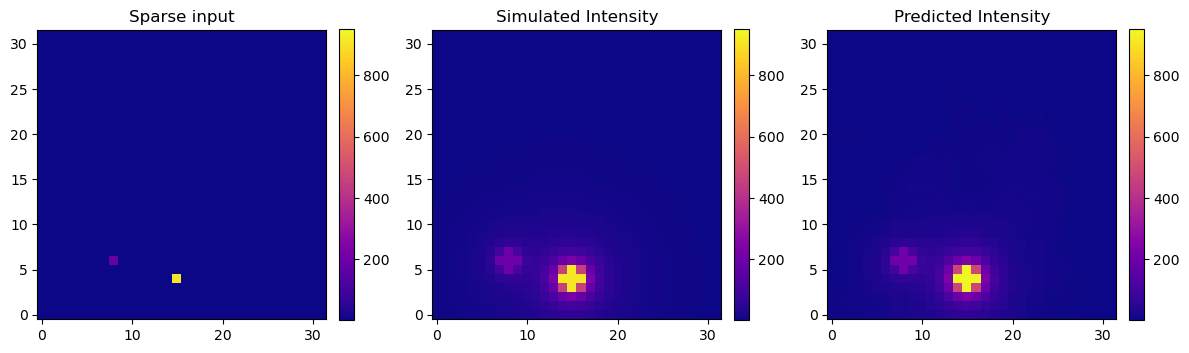

3 sources,  RMSE = 4.0


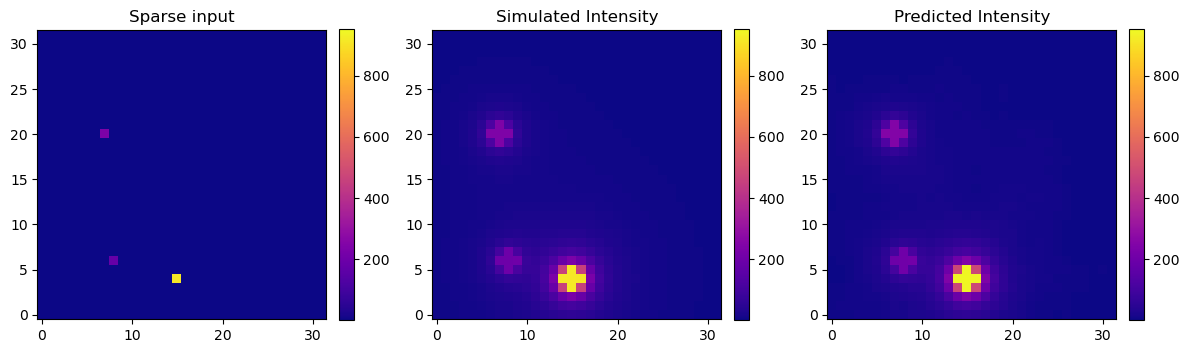

4 sources,  RMSE = 4.3


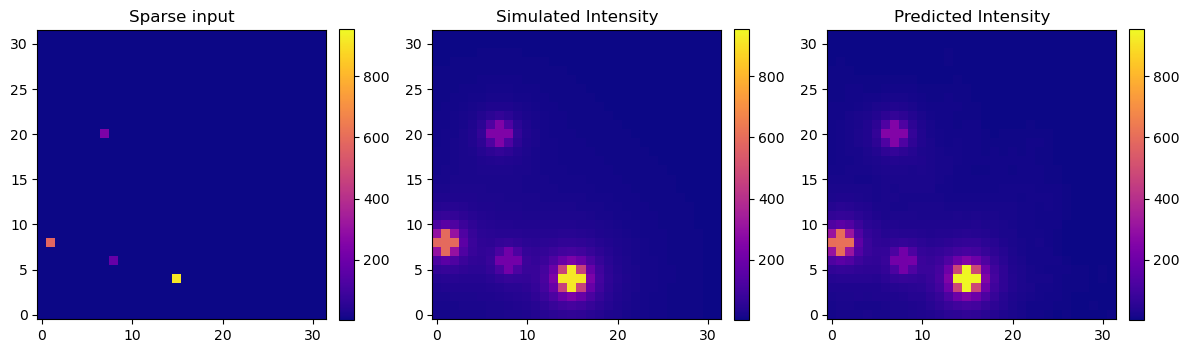

5 sources,  RMSE = 4.5


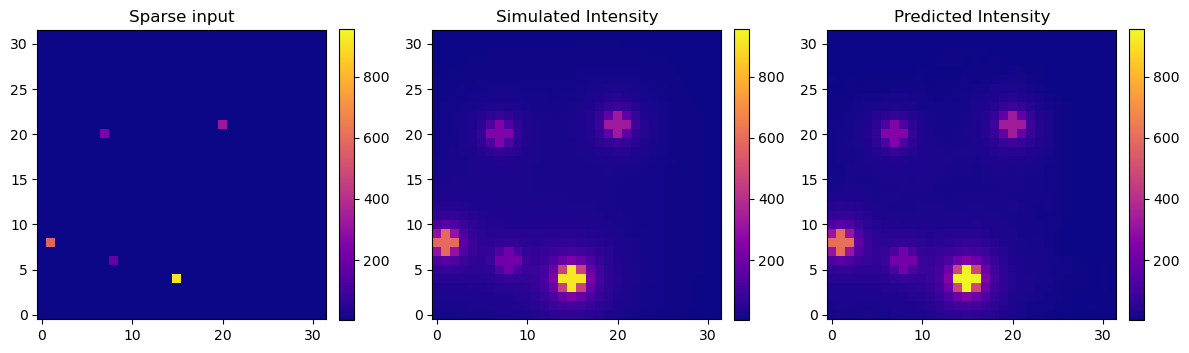

6 sources,  RMSE = 5.3


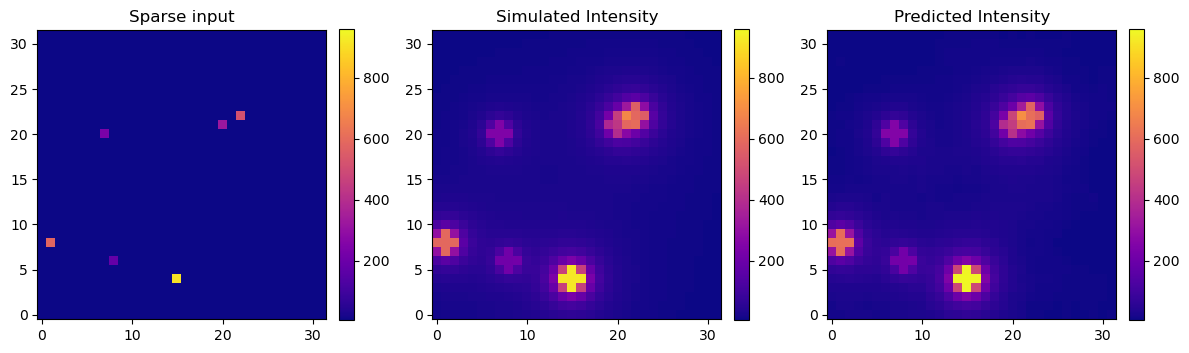

In [31]:
for num_sources in range(1,num_random_sources+1):
    
    # select subset from predefined sources
    sources = test_sources[0:num_sources]
    
    # source matrix
    test_sources_matrix = make_source_matrix(heatmap_h, heatmap_w, sources) 
    test_X = test_sources_matrix.reshape((1,heatmap_w * heatmap_h))

    # target intesity heatmap
    test_target = make_intensity_matrix(heatmap_h, heatmap_w, sources)

    # predicted intesity heatmap
    test_preds = model.predict(test_X, verbose = 0)
    test_pred = test_preds[0].reshape((heatmap_w, heatmap_h))

    # display RMSE
    rmse = np.sqrt((np.square(test_pred - test_target)).mean())
    print(f"{num_sources} sources,  RMSE = {round(rmse,1)}")

    # plot
    plot_compare_heatmaps(test_sources_matrix, test_target, test_pred)

**Note:** This shows that the model that was trained using 3 sources can create the distribution for any number of sources. 

### Repeat with log-scaled data and model

1
1 sources,  RMSE = 1.1


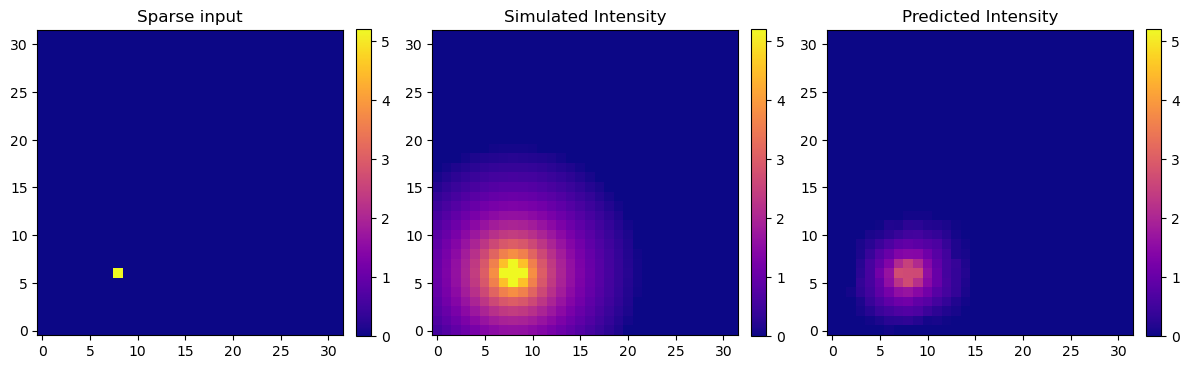

2 sources,  RMSE = 0.9


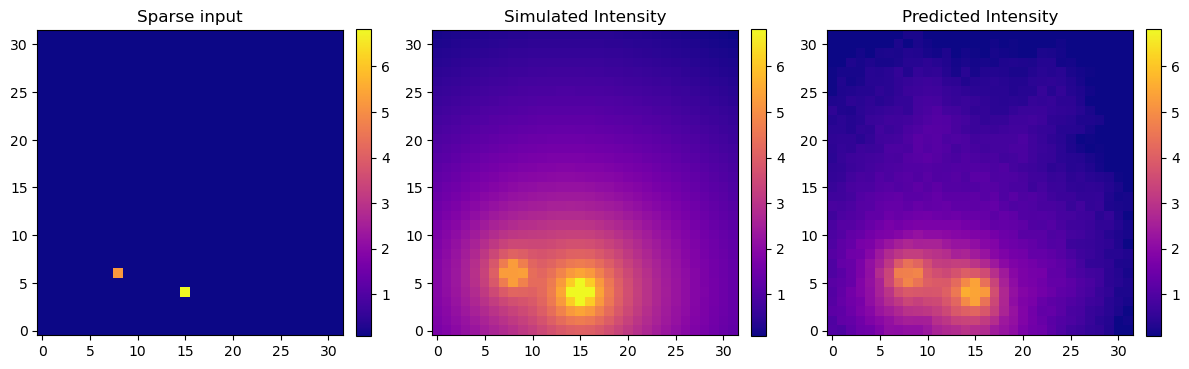

3 sources,  RMSE = 0.4


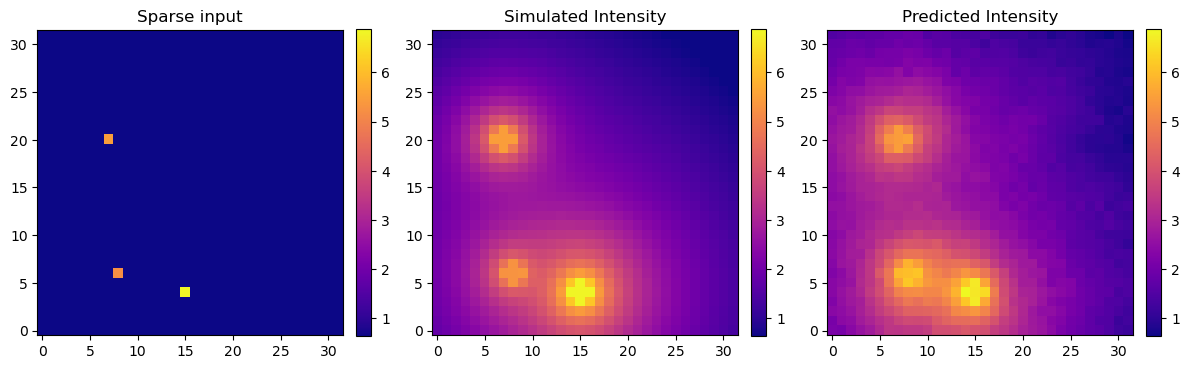

4 sources,  RMSE = 1.5


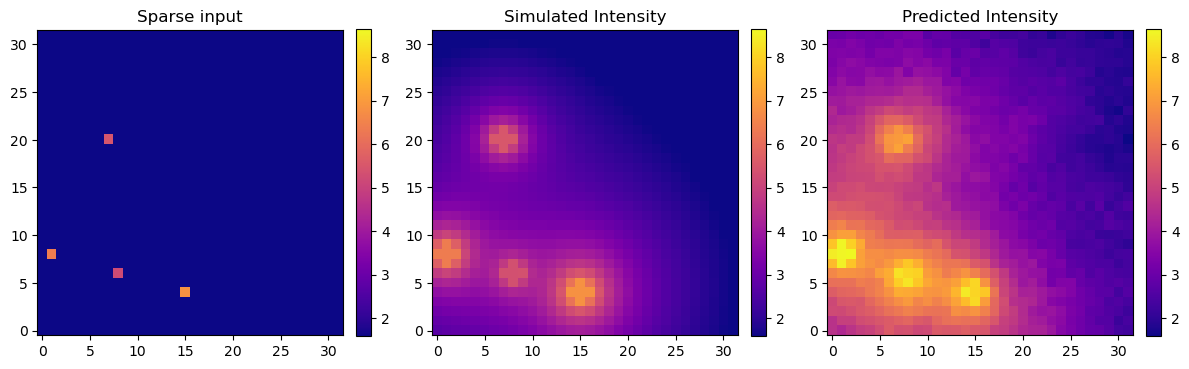

5 sources,  RMSE = 2.5


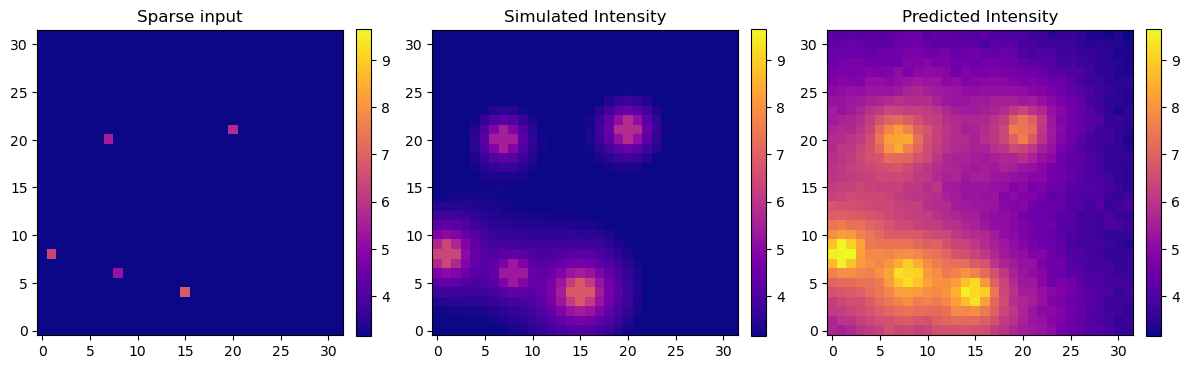

6 sources,  RMSE = 3.8


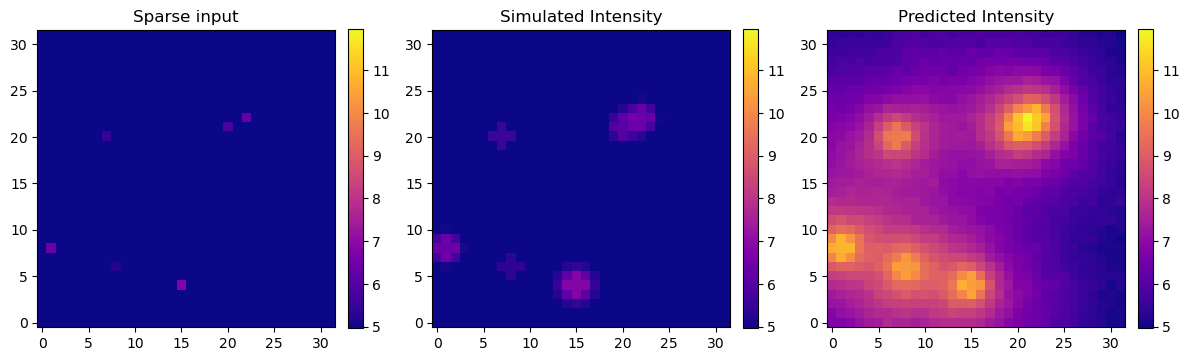

In [32]:
print(min_element)


for num_sources in range(1,num_random_sources+1):

    # select subset from predefined sources
    sources = test_sources[0:num_sources]    
    
    # source matrix
    test_sources_matrix = log_scale_matrix(make_source_matrix(heatmap_w, heatmap_h, sources), min_element)
    test_X = test_sources_matrix.reshape((1,heatmap_w * heatmap_h))


    # target intesity heatmap
    test_target = log_scale_matrix(make_intensity_matrix(heatmap_h, heatmap_w, sources), min_element)

    # predicted intesity heatmap
    test_preds = scaled_model.predict(test_X, verbose = 0)
    test_pred = test_preds[0].reshape((heatmap_w, heatmap_h))

    # display RMSE
    rmse = np.sqrt((np.square(test_pred - test_target)).mean())
    print(f"{num_sources} sources,  RMSE = {round(rmse,1)}")

    # plot
    plot_compare_heatmaps(test_sources_matrix, test_target, test_pred)




It seems that when the inputs are log-scaled, the range of intensities is lower and the noisiness of the predictions becomes a problem.

With few sources, the predicted source intensities are lower than the actual source intensties.

With more sources, the amount of noise accumulates causing the predicted sources to be more intense than the actual sources.

In [28]:
source_min

100